In [1]:
%autosave 0

import matplotlib.pyplot as plt
from math import sin, pi
import numpy as np
import torch

seed = 15
torch.manual_seed(seed)
np.random.seed(seed)

Autosave disabled


# Série temporelle à analyser

## génération de ma fonction sinus à prédire

In [2]:
time_steps = np.linspace(0,999,300)
A, omega, fi = 100, 0.03, 3
data = A*np.sin(omega*time_steps+fi)
data.resize((len(data), 1)) # input_size=1

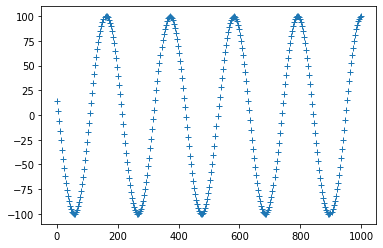

In [3]:
plt.plot(time_steps, data, '+');

## séparation en données d'entraînement et de validation

In [4]:
val = data[int(len(data)*.8):]
time_steps_val = time_steps[int(len(data)*.8):]

train = data[:int(len(data)*.8)]
time_steps_train = time_steps[:int(len(data)*.8)]

print(len(train))
print(len(time_steps_train))
print(len(val))
print(len(time_steps_val))

240
240
60
60


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class CleanBasicRNN(nn.Module):
    def __init__(self, batch_size, n_inputs, n_neurons):
        super(CleanBasicRNN, self).__init__()
        
        self.rnn = nn.RNNCell(n_inputs, n_neurons)
        self.hx = torch.randn(batch_size, n_neurons) # initialize hidden state
        
    def forward(self, X):
        output = []

        # for each time step
        for i in range(2):
            self.hx = self.rnn(X[i], self.hx)
            output.append(self.hx)
        
        return output, self.hx

# modèle RNN

## création du modèle

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        batch_size = x.size(0)

        r_out, hidden = self.rnn(x, hidden)
        r_out = r_out.view(-1, self.hidden_dim)  
        output = self.fc(r_out)
        
        return output, hidden

## fonction pour entraîner le modèle

In [7]:
# train the RNN
def train_model(rnn, n_steps, print_every, time_steps_train, train):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):       
        x = train[:-1]
        y = train[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps_train[1:], x, 'r.') # input
            plt.plot(time_steps_train[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn

## définition des hyperparamètres

In [8]:
# decide on hyperparameters
input_size=1 
output_size=1 # un seul point à prédire à la fois
hidden_dim=10 # on décide de regarder 10 points en arrière
n_layers=1 # modèle à une couche seulement

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

test_input = torch.Tensor(train).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

RNN(
  (rnn): RNN(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
Input size:  torch.Size([1, 240, 1])
Output size:  torch.Size([240, 1])
Hidden state size:  torch.Size([1, 1, 10])


In [9]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error

# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.2)

## entraînement du modèle et visualisation

Loss:  5048.39599609375


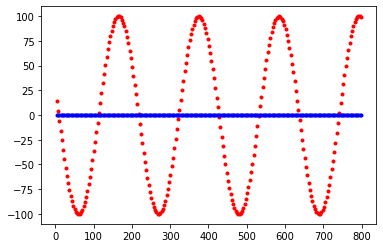

Loss:  227.80780029296875


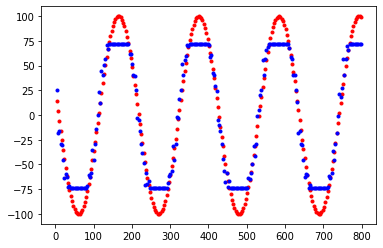

Loss:  157.41734313964844


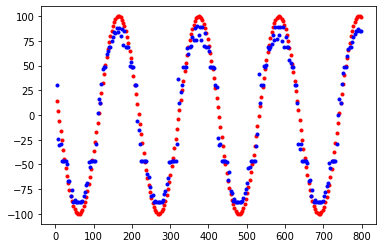

Loss:  58.186546325683594


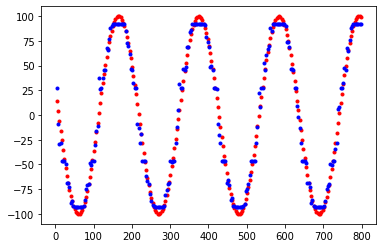

In [10]:
# train the rnn and monitor results
n_steps = 200 # nombre d'epoch à réaliser
prints_number = 4 # nombre de graphiques à afficher
print_every = int(n_steps / prints_number)

trained_rnn = train_model(rnn, n_steps, print_every,
                    time_steps_train, train)

## Evaluation of the model

In [11]:
# train the RNN
def evaluate_model(rnn, n_steps, time_steps_val, val):
    
    # initialize the hidden state
    hidden = None
        
    x = val[:-1]
    y = val[1:]

    # convert data into Tensors
    x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
    y_tensor = torch.Tensor(y)

    # outputs from the rnn
    prediction, hidden = rnn(x_tensor, hidden)

    ## Representing Memory ##
    # make a new variable for hidden and detach the hidden state from its history
    # this way, we don't backpropagate through the entire history
    hidden = hidden.data

    # calculate the loss
    loss = criterion(prediction, y_tensor)

    # display loss and predictions
    print('Loss: ', loss.item())
    plt.plot(time_steps_val[1:], x, 'r.') # input
    plt.plot(time_steps_val[1:], prediction.data.numpy().flatten(), 'b.') # predictions
    plt.show()
    
    return rnn

Loss:  42.060794830322266


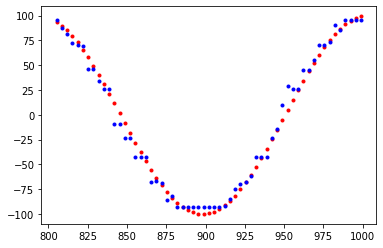

In [12]:
# train the rnn and monitor results
n_steps = 100

evaluate_rnn = evaluate_model(rnn, n_steps,
                    time_steps_val, val)

# modèle LSTM

## création du modèle

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers):
        super().__init__()
        
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

## définition des hyperparamètres

In [14]:
input_size=1
hidden_layer_size=10
output_size=1
num_layers=1

model = LSTM(input_size, hidden_layer_size, output_size, num_layers)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)

LSTM(
  (lstm): LSTM(1, 10)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)


## découpage du train avec fenêtre glissante

In [15]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [16]:
train_data_normalized = torch.FloatTensor(train).view(-1)

In [17]:
train_window = 10
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

## entraînement du modèle et visualisation

epoch:   9 loss: 1332.22827148


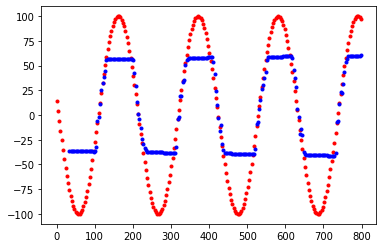

epoch:  19 loss: 2774.18457031


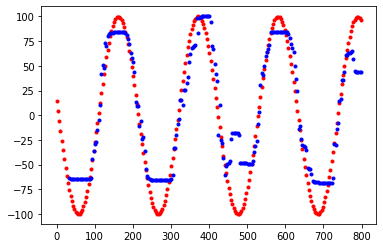

epoch:  29 loss: 124.03160095


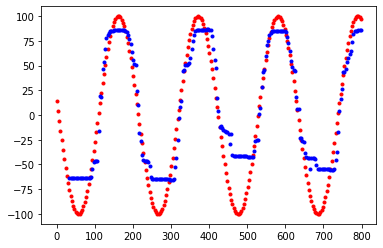

epoch:  39 loss: 26.58109283


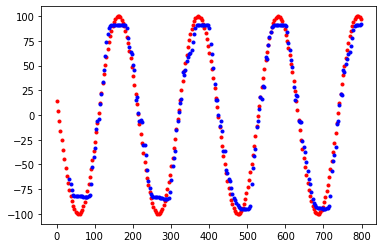

In [18]:
epochs = 40

for i in range(epochs):
    y_all = []
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
        y_all += [y_pred.data.numpy().flatten()[0]]

    if (i+1)%int(epochs/4) == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        plt.plot(time_steps_train, train, 'r.') # input
        plt.plot(time_steps_train[train_window:], y_all, 'b.') # predictions
        plt.show()

## évaluation du modèle

In [19]:
val_data_normalized = torch.FloatTensor(val).view(-1)

In [20]:
val_inout_seq = create_inout_sequences(val_data_normalized, train_window)

loss: 68.23948669


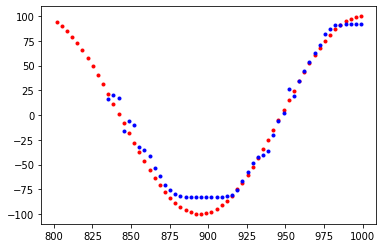

In [21]:
y_all = []
for seq, labels in val_inout_seq:
    y_pred = model(seq)

    single_loss = loss_function(y_pred, labels)

    y_all += [y_pred.data.numpy().flatten()[0]]

print(f'loss: {single_loss.item():10.8f}')
plt.plot(time_steps_val, val, 'r.') # input
plt.plot(time_steps_val[train_window:], y_all, 'b.') # predictions
plt.show()

# modèle GRU

## définition des hyperparamètres

In [50]:
input_size=1
hidden_layer_size=10
output_size=1
num_layers=1
learning_rate = 0.002

## création du modèle

model = torch.nn.Sequential(
    torch.nn.GRU(input_size, hidden_layer_size),
    torch.nn.Linear(hidden_layer_size, output_size),
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

In [51]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers):
        super().__init__()
        
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.GRU(input_size, hidden_layer_size, num_layers)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = torch.zeros(1,1,self.hidden_layer_size)

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = GRU(input_size, hidden_layer_size, output_size, num_layers)

## entraînement du modèle et visualisation

In [52]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch:   9 loss: 3722.21997070


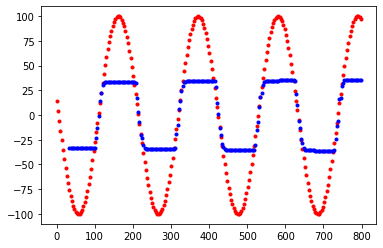

epoch:  19 loss: 1218.95739746


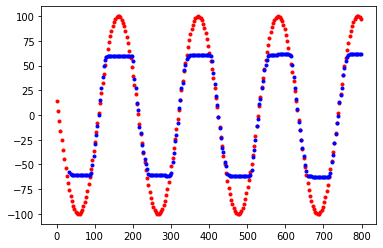

epoch:  29 loss: 272.14175415


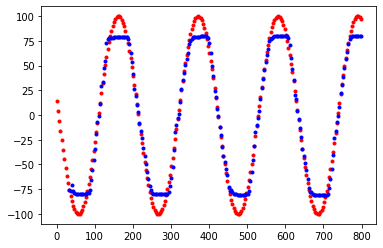

epoch:  39 loss: 35.23298264


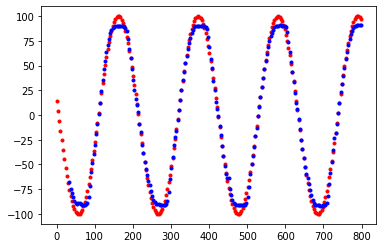

In [53]:
epochs = 40

for i in range(epochs):
    y_all = []
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        
        model.hidden_cell = torch.zeros(1, 1, hidden_layer_size)
        
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
        y_all += [y_pred.data.numpy().flatten()[0]]

    if (i+1)%int(epochs/4) == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        plt.plot(time_steps_train, train, 'r.') # input
        plt.plot(time_steps_train[train_window:], y_all, 'b.') # predictions
        plt.show()

## évaluation du modèle

In [54]:
val_data_normalized = torch.FloatTensor(val).view(-1)

In [55]:
val_inout_seq = create_inout_sequences(val_data_normalized, train_window)

loss: 80.98832703


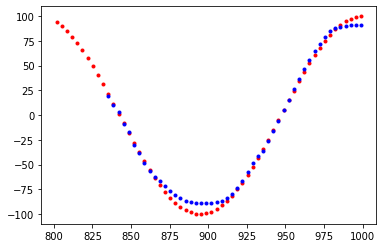

In [56]:
y_all = []
for seq, labels in val_inout_seq:
    y_pred = model(seq)

    single_loss = loss_function(y_pred, labels)

    y_all += [y_pred.data.numpy().flatten()[0]]

print(f'loss: {single_loss.item():10.8f}')
plt.plot(time_steps_val, val, 'r.') # input
plt.plot(time_steps_val[train_window:], y_all, 'b.') # predictions
plt.show()